In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2
# import wandb
# from wandb.fastai import WandbCallback

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[15:26]) == "AOI_2_Vegas"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_2_Vegas_img4980.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_2_Vegas_img506.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_2_Vegas_img3269.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_2_Vegas_img2570.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_2_Vegas_img4395.tif')]

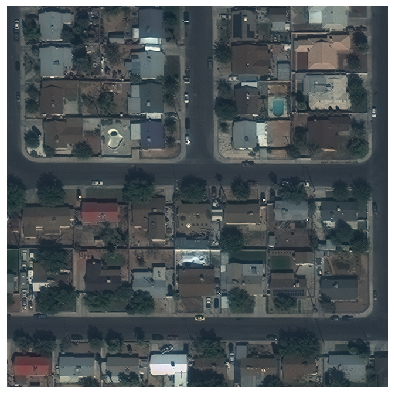

In [6]:
img = open_image(fname[12])
img.show(figsize=(7,7))

In [5]:
# string = 'Images/'
# data = [string + x.name for x in fname]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Vegas_buildings.csv")

In [5]:
vegas_df = pd.read_csv(path/'Vegas_buildings.csv')
vegas_df = vegas_df.drop(columns = 'Unnamed: 0')
vegas_df.head()

,Images
0,Images/RGB-PanSharpen_AOI_2_Vegas_img4980.tif
1,Images/RGB-PanSharpen_AOI_2_Vegas_img506.tif
2,Images/RGB-PanSharpen_AOI_2_Vegas_img3269.tif
3,Images/RGB-PanSharpen_AOI_2_Vegas_img2570.tif
4,Images/RGB-PanSharpen_AOI_2_Vegas_img4395.tif


In [6]:
len(vegas_df)

3851

In [7]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [8]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [9]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(vegas_df, path).
      split_by_rand_pct(.1).
      label_from_func(get_y_fn, classes=codes))

In [10]:
bs = 32
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.5, max_lighting = 0.4), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

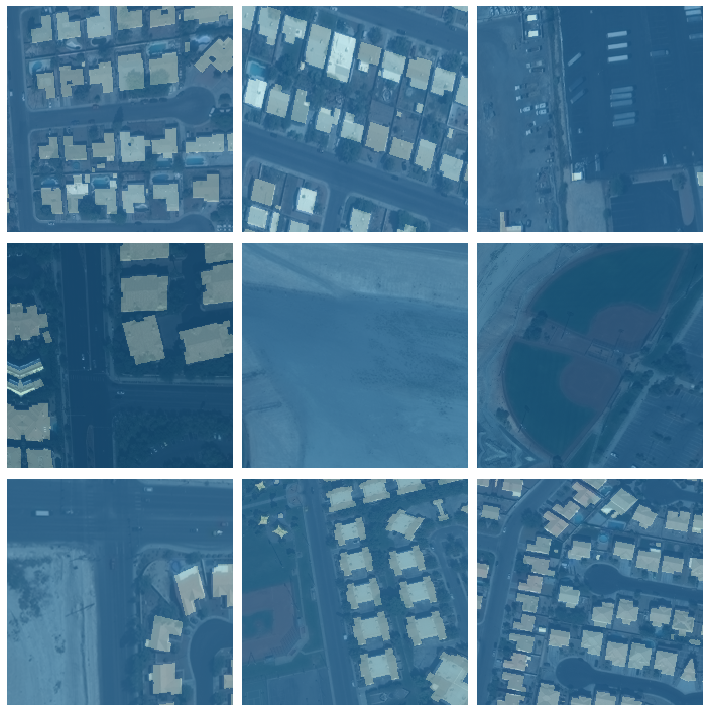

In [14]:
data.show_batch(3, figsize=(10,10))

In [12]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, 
                     norm_type=NormType.Weight, self_attention=True)
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


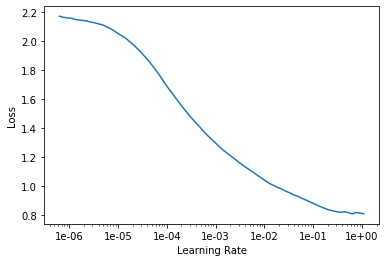

In [13]:
learn.lr_find()
learn.recorder.plot() 

In [14]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,dice,time
0,0.340053,0.256920,0.434312,00:50
1,0.224707,0.216615,0.645033,00:49
2,0.191353,0.172693,0.684336,00:49
3,0.162774,0.158380,0.702996,00:49
4,0.152391,0.155669,0.715312,00:49


In [15]:
save_model(learn, 'Vegas', 'F', 'smol', 1)

# Start Recording

In [10]:
import wandb
from wandb.fastai import WandbCallback

In [17]:
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [18]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Vegas.ipynb"

In [19]:
wandb.init(project="spacenet_buildings", name = 'Vegas_smol')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/qrrzpvcn

In [21]:
load_model(learn, 'Vegas', 'F', 'smol', 1)

In [22]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.148882,0.154354,0.715614,00:49
1,0.149895,0.155199,0.720796,00:49
2,0.146957,0.151034,0.726475,00:49
3,0.149349,0.166806,0.719204,00:49
4,0.145150,0.149566,0.732861,00:49
5,0.145027,0.142859,0.731193,00:49
6,0.138909,0.143284,0.743792,00:48
7,0.131745,0.130323,0.758925,00:49
8,0.125237,0.129545,0.761684,00:49
9,0.120354,0.128566,0.763473,00:49


Better model found at epoch 0 with valid_loss value: 0.15435396134853363.
Better model found at epoch 2 with valid_loss value: 0.15103358030319214.
Better model found at epoch 4 with valid_loss value: 0.14956633746623993.
Better model found at epoch 5 with valid_loss value: 0.14285853505134583.
Better model found at epoch 7 with valid_loss value: 0.13032296299934387.
Better model found at epoch 8 with valid_loss value: 0.12954497337341309.
Better model found at epoch 9 with valid_loss value: 0.12856636941432953.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_150842-qrrzpvcn/bestmodel.pth


In [24]:
save_model(learn, 'Vegas', 'F', 'smol', 2)

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.120214,0.128282,0.763921,00:51
1,0.121398,0.129051,0.763062,00:51
2,0.120378,0.128962,0.758472,00:51
3,0.120741,0.128852,0.759129,00:50
4,0.118510,0.127997,0.764133,00:51
5,0.117748,0.126071,0.768952,00:51
6,0.118312,0.130400,0.760343,00:51
7,0.116481,0.127035,0.768102,00:51
8,0.116406,0.124957,0.769127,00:51
9,0.113178,0.124303,0.772023,00:51


Better model found at epoch 0 with valid_loss value: 0.1282818615436554.
Better model found at epoch 4 with valid_loss value: 0.12799659371376038.
Better model found at epoch 5 with valid_loss value: 0.1260710060596466.
Better model found at epoch 8 with valid_loss value: 0.12495747208595276.
Better model found at epoch 9 with valid_loss value: 0.12430287152528763.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_150842-qrrzpvcn/bestmodel.pth


In [27]:
save_model(learn, 'Vegas', 'UF', 'smol', 1)

In [28]:
learn.fit_one_cycle(5, slice(1e-4, 1e-3), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.115062,0.132917,0.762611,00:51
1,0.130783,0.147458,0.749172,00:51
2,0.155255,0.143729,0.744436,00:51
3,0.137102,0.129919,0.762693,00:51
4,0.122521,0.123967,0.771401,00:51


Better model found at epoch 0 with valid_loss value: 0.13291651010513306.
Better model found at epoch 3 with valid_loss value: 0.1299191564321518.
Better model found at epoch 4 with valid_loss value: 0.12396734952926636.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_150842-qrrzpvcn/bestmodel.pth


In [29]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.119380,0.123124,0.771943,00:51
1,0.118289,0.123396,0.771560,00:51
2,0.117260,0.122359,0.771958,00:51
3,0.117205,0.121947,0.773072,00:51
4,0.117157,0.122068,0.772436,00:51
5,0.116327,0.121363,0.772840,00:50
6,0.115565,0.119652,0.776806,00:50
7,0.115347,0.120464,0.775854,00:51
8,0.114025,0.118765,0.777031,00:51
9,0.113748,0.118877,0.777660,00:51


Better model found at epoch 0 with valid_loss value: 0.12312367558479309.
Better model found at epoch 2 with valid_loss value: 0.12235909700393677.
Better model found at epoch 3 with valid_loss value: 0.12194713950157166.
Better model found at epoch 5 with valid_loss value: 0.1213633343577385.
Better model found at epoch 6 with valid_loss value: 0.11965196579694748.
Better model found at epoch 8 with valid_loss value: 0.11876531690359116.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_150842-qrrzpvcn/bestmodel.pth


In [30]:
save_model(learn, 'Vegas', 'UF', 'small', 2)

## GO BIG

In [11]:
bs = 8
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.5, max_lighting = 0.4), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [12]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [13]:
load_model(learn, 'Vegas', 'UF', 'small', 2)

In [14]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Vegas.ipynb"

In [15]:
wandb.init(project="spacenet_buildings", name = 'Vegas_Big_SA')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/wu0sxxqj

In [16]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.132846,0.103721,0.796749,02:47
1,0.129810,0.104454,0.794469,02:37
2,0.128158,0.106307,0.798785,02:37
3,0.122290,0.102863,0.798449,02:37
4,0.122836,0.102294,0.800490,02:38
5,0.122664,0.100088,0.807259,02:37
6,0.123609,0.112337,0.794668,02:37
7,0.113290,0.093883,0.821002,02:37
8,0.106247,0.091834,0.823749,02:37
9,0.096121,0.088616,0.827328,02:37


Better model found at epoch 0 with valid_loss value: 0.1037207767367363.
Better model found at epoch 3 with valid_loss value: 0.10286304354667664.
Better model found at epoch 4 with valid_loss value: 0.1022944375872612.
Better model found at epoch 5 with valid_loss value: 0.10008767992258072.
Better model found at epoch 7 with valid_loss value: 0.09388282150030136.
Better model found at epoch 8 with valid_loss value: 0.09183379262685776.
Better model found at epoch 9 with valid_loss value: 0.08861559629440308.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_161346-wu0sxxqj/bestmodel.pth


In [17]:
save_model(learn, 'Vegas', 'F', 'big', 1)

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.096787,0.089098,0.827316,02:43
1,0.097731,0.088827,0.827250,02:42
2,0.102784,0.088823,0.827648,02:43
3,0.091367,0.088301,0.827217,02:42
4,0.103129,0.090775,0.823057,02:43
5,0.096583,0.088554,0.828657,02:43
6,0.094640,0.087738,0.829936,02:42
7,0.087400,0.087096,0.829330,02:43
8,0.092426,0.086144,0.829804,02:43
9,0.090529,0.085739,0.831135,02:43


Better model found at epoch 0 with valid_loss value: 0.08909843862056732.
Better model found at epoch 1 with valid_loss value: 0.0888269916176796.
Better model found at epoch 2 with valid_loss value: 0.08882251381874084.
Better model found at epoch 3 with valid_loss value: 0.08830104023218155.
Better model found at epoch 6 with valid_loss value: 0.08773846179246902.
Better model found at epoch 7 with valid_loss value: 0.08709605038166046.
Better model found at epoch 8 with valid_loss value: 0.086144357919693.
Better model found at epoch 9 with valid_loss value: 0.08573898673057556.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_161346-wu0sxxqj/bestmodel.pth


In [20]:
save_model(learn, 'Vegas', 'UF', 'big', 1)

In [21]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.088137,0.085829,0.831805,02:42
1,0.091698,0.085573,0.831729,02:43
2,0.090366,0.085849,0.831641,02:42
3,0.089632,0.086699,0.830386,02:42
4,0.091077,0.084685,0.834190,02:42
5,0.092577,0.085955,0.832722,02:43
6,0.092042,0.086502,0.832527,02:43
7,0.087184,0.084672,0.834650,02:43
8,0.088918,0.084789,0.834877,02:43
9,0.087208,0.084541,0.834279,02:42


Better model found at epoch 0 with valid_loss value: 0.08582949638366699.
Better model found at epoch 1 with valid_loss value: 0.08557260781526566.
Better model found at epoch 4 with valid_loss value: 0.08468513190746307.
Better model found at epoch 7 with valid_loss value: 0.08467219769954681.
Better model found at epoch 9 with valid_loss value: 0.0845412090420723.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_161346-wu0sxxqj/bestmodel.pth


In [22]:
save_model(learn, 'Vegas', 'UF', 'big', 2)

In [23]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.085112,0.084516,0.834318,02:42
1,0.087743,0.084383,0.833966,02:43
2,0.086830,0.084466,0.834229,02:43
3,0.090539,0.084495,0.833979,02:43
4,0.084924,0.084382,0.834635,02:43
5,0.089125,0.084548,0.834136,02:43
6,0.091222,0.084208,0.834597,02:43
7,0.087437,0.084514,0.834188,02:43
8,0.088492,0.084130,0.834666,02:43
9,0.085783,0.084397,0.834371,02:43


Better model found at epoch 0 with valid_loss value: 0.08451596647500992.
Better model found at epoch 1 with valid_loss value: 0.08438260853290558.
Better model found at epoch 4 with valid_loss value: 0.08438223600387573.
Better model found at epoch 6 with valid_loss value: 0.0842081606388092.
Better model found at epoch 8 with valid_loss value: 0.08412959426641464.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_161346-wu0sxxqj/bestmodel.pth


In [24]:
save_model(learn, 'Vegas', 'UF', 'big', 3)